In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", as_frame = False)
print(type(mnist))
X = mnist["data"]
y = mnist["target"]

<class 'sklearn.utils._bunch.Bunch'>


In [5]:
def graph_img(img):
    img = img.reshape(28, 28)
    plt.imshow(img, cmap = "binary") # display as grayscale
    plt.axis("off")

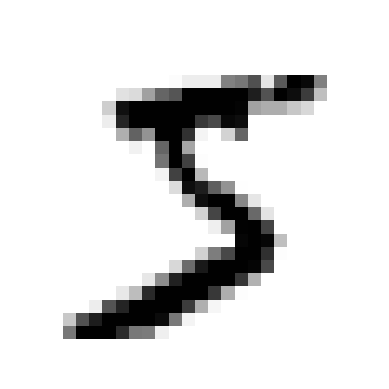

In [7]:
graph_img(X[0])

In [9]:
# split the data
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### Part 1: Train a Binary Classifier

In [12]:
y_train_5 = (y_train == "5")
y_test_5 = (y_test == "5")

**Train SGD Classifier**

In [15]:
from sklearn.linear_model import SGDClassifier
sgd_class = SGDClassifier(random_state = 42)
sgd_class.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

**Evaluate Performance**

In [17]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_class, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [20]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred_5 = cross_val_predict(sgd_class, X_train, y_train_5, cv = 3)
confusion_matrix(y_train_5, y_train_pred_5)

array([[53892,   687],
       [ 1891,  3530]])

In [22]:
from sklearn.metrics import precision_score, recall_score
print(f"Precision: {precision_score(y_train_5, y_train_pred_5)}")
print(f"Recall (Sensitivity): {recall_score(y_train_5, y_train_pred_5)}")

Precision: 0.8370879772350012
Recall (Sensitivity): 0.6511713705958311


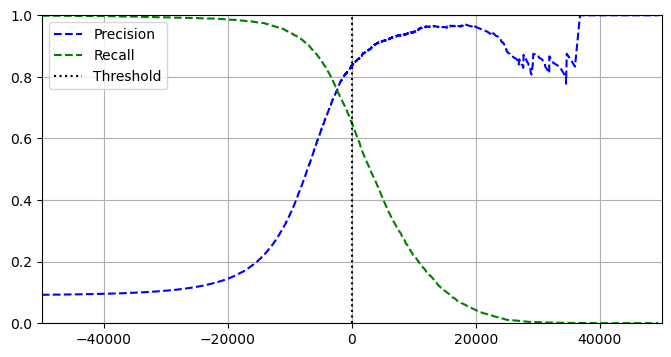

In [24]:
from sklearn.metrics import precision_recall_curve
y_scores_sgd = cross_val_predict(sgd_class, X_train, y_train_5, cv = 3, method = "decision_function")
sgd_precisions, sgd_recalls, sgd_thresholds = precision_recall_curve(y_train_5, y_scores_sgd)
# plot the curve
plt.figure(figsize=(8, 4))
plt.plot(sgd_thresholds, sgd_precisions[:-1], "b--", label = "Precision")
plt.plot(sgd_thresholds, sgd_recalls[:-1], "g--", label = "Recall")
plt.vlines(0, ymin = 0, ymax = 1, colors = "k", linestyles = "dotted", label = "Threshold") # threshold = 0 for sgd
plt.axis([-50000, 50000, 0, 1])
plt.legend()
plt.grid()
plt.show()

In [26]:
# select threshold, predict and evaluate
threshold_90_prec = sgd_thresholds[(sgd_precisions >= 0.90).argmax()]
y_train_pred_90 = (y_scores_sgd >= threshold_90_prec)
print(f"Precision: {precision_score(y_train_5, y_train_pred_90)}")
print(f"Recall: {recall_score(y_train_5, y_train_pred_90)}")

Precision: 0.9000345901072293
Recall: 0.4799852425751706


For threshold = 0:\
Precision = 0.837, Recall = 0.651\
Note the precision-recall tradeoff

ROC AUC: 0.9604938554008616


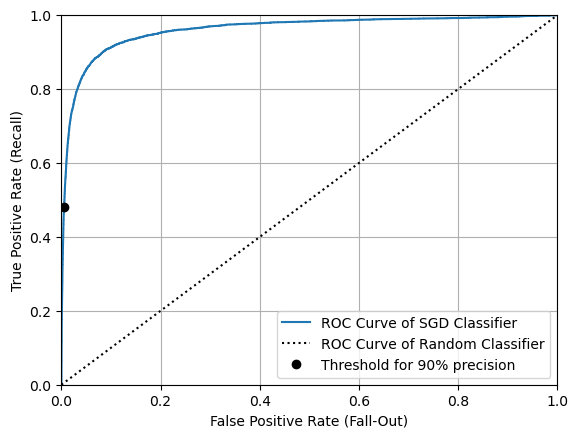

In [31]:
# graph roc curve
from sklearn.metrics import roc_curve, roc_auc_score
sgd_fpr, sgd_tpr, sgd_thresholds = roc_curve(y_train_5, y_scores_sgd)
# find fpr and tpr for minimum threshold where precision > 90%
index = (sgd_thresholds <= threshold_90_prec).argmax()
fpr_90_prec = sgd_fpr[index]
tpr_90_prec = sgd_tpr[index]
print(f"ROC AUC: {roc_auc_score(y_train_5, y_scores_sgd)}")
# plot
plt.plot(sgd_fpr, sgd_tpr, label = "ROC Curve of SGD Classifier")
plt.plot(sgd_fpr, sgd_fpr, "k:", label = "ROC Curve of Random Classifier")
plt.plot(fpr_90_prec, tpr_90_prec, "ko", label = "Threshold for 90% precision")
plt.grid()
plt.legend()
plt.axis([0, 1, 0, 1])
plt.xlabel("False Positive Rate (Fall-Out)")
plt.ylabel("True Positive Rate (Recall)")
plt.show()

**Train RandomForestClassifier**

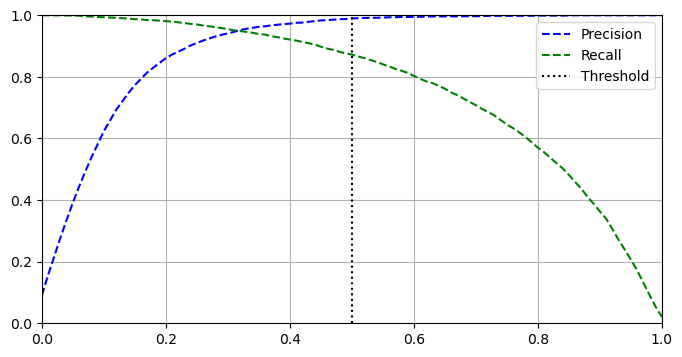

In [34]:
from sklearn.ensemble import RandomForestClassifier
forest_class = RandomForestClassifier(random_state = 42)
y_scores_forest = cross_val_predict(forest_class, X_train, y_train_5,
                                   cv = 3, method = "predict_proba")[:,1] # just probability for positive class
forest_precisions, forest_recalls, forest_thresholds = precision_recall_curve(y_train_5, y_scores_forest)
plt.figure(figsize=(8, 4))
plt.plot(forest_thresholds, forest_precisions[:-1], "b--", label = "Precision")
plt.plot(forest_thresholds, forest_recalls[:-1], "g--", label = "Recall")
threshold = 0.5
plt.vlines(threshold, ymin = 0, ymax = 1, colors = "k", linestyles = "dotted", label = "Threshold")
plt.legend(loc = "upper right")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.show()

**Compare SGD and RandomForest Performances**

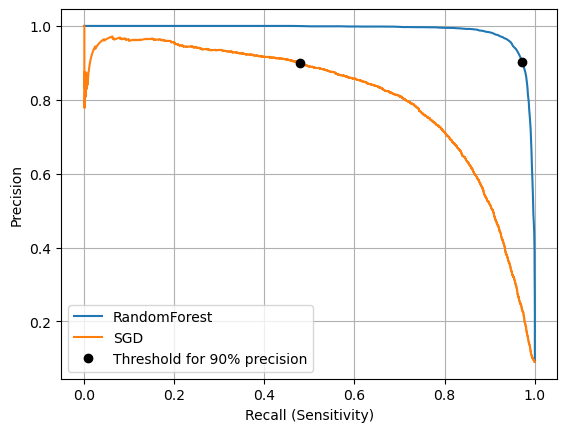

In [37]:
# compare sgd and random forest precision-recall curves
plt.plot(forest_recalls, forest_precisions, label = "RandomForest")
plt.plot(sgd_recalls, sgd_precisions, label = "SGD")
sgd_90_prec_idx = (sgd_precisions >= 0.9).argmax()
forest_90_prec_idx = (forest_precisions >= 0.9).argmax()
plt.plot([sgd_recalls[sgd_90_prec_idx], forest_recalls[forest_90_prec_idx]],
         [sgd_precisions[sgd_90_prec_idx], forest_precisions[forest_90_prec_idx]],
         "ko", label = "Threshold for 90% precision")
plt.grid()
plt.legend()
plt.xlabel("Recall (Sensitivity)")
plt.ylabel("Precision")
plt.show()

SGD Classifier: 0.9604938554008616
RandomForest Classifier: 0.9983436731328145


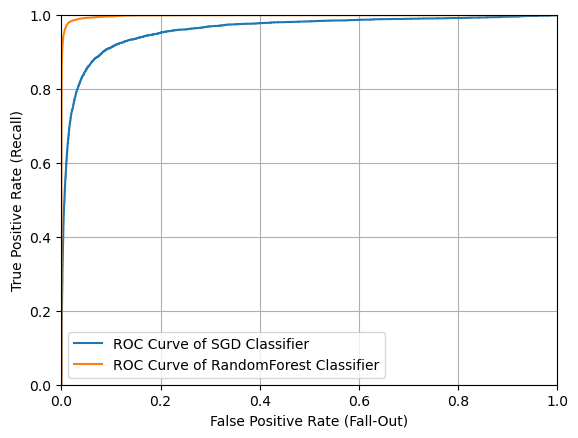

In [39]:
# compare roc curves and roc auc
print(f"SGD Classifier: {roc_auc_score(y_train_5, y_scores_sgd)}")
print(f"RandomForest Classifier: {roc_auc_score(y_train_5, y_scores_forest)}")
plt.plot(sgd_fpr, sgd_tpr, label = "ROC Curve of SGD Classifier")
forest_fpr, forest_tpr, forest_thresholds = roc_curve(y_train_5, y_scores_forest)
plt.plot(forest_fpr, forest_tpr, label = "ROC Curve of RandomForest Classifier")
plt.grid()
plt.legend()
plt.axis([0, 1, 0, 1])
plt.xlabel("False Positive Rate (Fall-Out)")
plt.ylabel("True Positive Rate (Recall)")
plt.show()

### Part 2: Multiclass Classification
**SVC (Binary OvO Classifier)**

In [42]:
# train SVC (binary classifier)
from sklearn.svm import SVC

svm_class = SVC(random_state = 42)
svm_class.fit(X_train[:2000], y_train[:2000]) # run on multiclass label; only first 2000 to limit computational costs

SVC(random_state=42)

In [44]:
print(f"Classification of X[0]: {svm_class.predict([X[0]])}")
print(f"Decision Function Scores: {svm_class.decision_function([X[0]]).round(2)}")

Classification of X[0]: ['5']
Decision Function Scores: [[ 3.79  0.73  6.06  8.3  -0.29  9.3   1.75  2.77  7.21  4.82]]


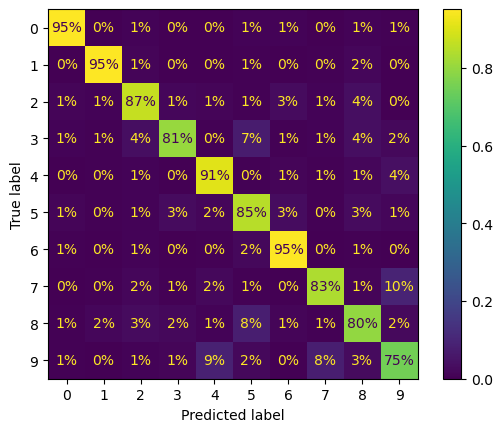

In [46]:
# evaluate with confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
y_train_pred = cross_val_predict(sgd_class, X_train, y_train, cv = 3)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize = "true", values_format = ".0%")
plt.show()

In [48]:
# further evaluation
print(f"Precision: {precision_score(y_train, y_train_pred, average = "weighted")}")
print(f"Recall: {recall_score(y_train, y_train_pred, average = "weighted")}")

Precision: 0.8677352903321172
Recall: 0.8669666666666667


### Part 3: Multilabel (Multiclass) Classification
Train a KNN model to remove noise from images\
Add noise to training set, labels are the cleaned up pixels, classes are the pixel intensities\
Total: 28 x 28 = 784 labels (pixels) + 256 classes (pixel intensities)

In [51]:
# add noise to training and testing set
np.random.seed(42)
training_noise = np.random.randint(low = 0, high = 100, size = (len(X_train), 784)) # 784 random pixel intensities for each image
testing_noise = np.random.randint(low = 0, high = 100, size = (len(X_test), 784))
X_train_noise = X_train + training_noise
X_test_noise = X_test + testing_noise
y_train_noise = X_train
y_test_noise = X_test

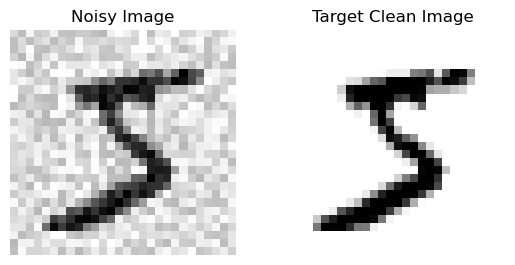

In [53]:
# examine noisy images
plt.subplot(1, 2, 1)
graph_img(X_train_noise[0])
plt.title("Noisy Image")
plt.subplot(1, 2, 2)
graph_img(y_train_noise[0])
plt.title("Target Clean Image")
plt.show()

In [55]:
# train knn to clean up image
from sklearn.neighbors import KNeighborsClassifier
knn_class = KNeighborsClassifier()
knn_class.fit(X_train_noise, y_train_noise)

KNeighborsClassifier()

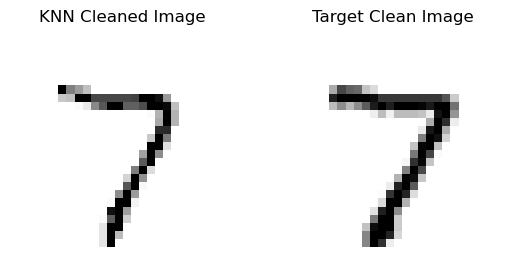

In [56]:
# visualize w/ one img
plt.subplot(1, 2, 1)
graph_img(knn_class.predict([X_test_noise[0]]))
plt.title("KNN Cleaned Image")
plt.subplot(1, 2, 2)
graph_img(y_test_noise[0])
plt.title("Target Clean Image")
plt.show()

In [57]:
# run random forest on cleaned images to see if performance improved
from sklearn.metrics import accuracy_score, f1_score
fr_clf = RandomForestClassifier(random_state=42)
fr_clf.fit(X_train, y_train)
cleaned_preds = fr_clf.predict(knn_class.predict(X_test_noise[:2000]))
print(f"Accuracy: {accuracy_score(y_test[:2000], cleaned_preds)}")
print(f"Precision: {precision_score(y_test[:2000], cleaned_preds, average = "weighted")}")
print(f"Recall: {recall_score(y_test[:2000], cleaned_preds, average = "weighted")}")
print(f"F1 Score: {f1_score(y_test[:2000], cleaned_preds, average = "weighted")}")

Accuracy: 0.9005
Precision: 0.9082203122588134
Recall: 0.9005
F1 Score: 0.8986548963672384
